# Memoria M0_2 a) Localizar ROIS

## Imports

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
from skimage import io
import matplotlib
from PIL import Image

## Load csv data

In [2]:
# Read csv file
df = pd.read_csv('./REY_DATASET/traza_REY.csv', sep='; ',header=None)
df.head()

/home/irene/anaconda3/envs/snowflakes/lib/python3.7/site-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


0                                      1  \
0  id:0   fname:ROI_0_Psic_012Ev1.pdf_pg-7.png   
1  id:1  fname:ROI_0_Psic_502Ev2.pdf_pg-23.png   
2  id:3  fname:ROI_0_Psic_202Ev5.pdf_pg-29.png   
3  id:4  fname:ROI_0_Psic_237Ev4.pdf_pg-24.png   
4  id:5  fname:ROI_0_Psic_421Ev1.pdf_pg-36.png   

                                 2                        3       4  
0   forig:Psic_012Ev1.pdf_pg-7.jpg  BB:[187, 221, 200, 182]   rot:0  
1  forig:Psic_502Ev2.pdf_pg-23.jpg  BB:[209, 349, 360, 250]  rot:90  
2  forig:Psic_202Ev5.pdf_pg-29.jpg   BB:[37, 211, 419, 548]   rot:0  
3  forig:Psic_237Ev4.pdf_pg-24.jpg   BB:[61, 197, 371, 434]   rot:0  
4  forig:Psic_421Ev1.pdf_pg-36.jpg  BB:[120, 204, 439, 306]  rot:90

In [3]:
df.columns = ['id','fname','forig','BB','rot']
df.head()

id                                  fname  \
0  id:0   fname:ROI_0_Psic_012Ev1.pdf_pg-7.png   
1  id:1  fname:ROI_0_Psic_502Ev2.pdf_pg-23.png   
2  id:3  fname:ROI_0_Psic_202Ev5.pdf_pg-29.png   
3  id:4  fname:ROI_0_Psic_237Ev4.pdf_pg-24.png   
4  id:5  fname:ROI_0_Psic_421Ev1.pdf_pg-36.png   

                             forig                       BB     rot  
0   forig:Psic_012Ev1.pdf_pg-7.jpg  BB:[187, 221, 200, 182]   rot:0  
1  forig:Psic_502Ev2.pdf_pg-23.jpg  BB:[209, 349, 360, 250]  rot:90  
2  forig:Psic_202Ev5.pdf_pg-29.jpg   BB:[37, 211, 419, 548]   rot:0  
3  forig:Psic_237Ev4.pdf_pg-24.jpg   BB:[61, 197, 371, 434]   rot:0  
4  forig:Psic_421Ev1.pdf_pg-36.jpg  BB:[120, 204, 439, 306]  rot:90

In [4]:
for its in df.columns:
    df[its] = df[its].map(lambda x: x.lstrip(its+':'))
df.head()

id                            fname                      forig  \
0  0   ROI_0_Psic_012Ev1.pdf_pg-7.png   Psic_012Ev1.pdf_pg-7.jpg   
1  1  ROI_0_Psic_502Ev2.pdf_pg-23.png  Psic_502Ev2.pdf_pg-23.jpg   
2  3  ROI_0_Psic_202Ev5.pdf_pg-29.png  Psic_202Ev5.pdf_pg-29.jpg   
3  4  ROI_0_Psic_237Ev4.pdf_pg-24.png  Psic_237Ev4.pdf_pg-24.jpg   
4  5  ROI_0_Psic_421Ev1.pdf_pg-36.png  Psic_421Ev1.pdf_pg-36.jpg   

                     BB rot  
0  [187, 221, 200, 182]   0  
1  [209, 349, 360, 250]  90  
2   [37, 211, 419, 548]   0  
3   [61, 197, 371, 434]   0  
4  [120, 204, 439, 306]  90

## Load images

In [5]:
img_h, img_w = 900, 600 # desired dimensions
reduct = 0.2 # reduction factor
redim_vec = [it*reduct for it in [img_w,img_h,img_h,img_w]] # vector used to scale dimensions

### Preprocessing

In [6]:
# add white pixels to fit all images into the same size
def adjust_dims(img,b,r):
    size = img.shape[:2]
    color = [255,255,255]
    bottom = b-size[0]
    right = r-size[1]
    out_img = cv2.copyMakeBorder(img, 0,bottom,0,right,cv2.BORDER_CONSTANT,value=color)
    return out_img

# reduce images size
from skimage.transform import rescale, resize
def reduce_imgs(img, reduct):
    img = resize(img, (img.shape[0]*reduct, img.shape[1]*reduct), anti_aliasing=False)
    return img

# thresholding gray images
from skimage.filters import threshold_otsu
def thresh_imgs(img):
    thresh = threshold_otsu(img)
    binary = img > thresh
    return binary

In [7]:
path = './REY_DATASET/REY_scan_anonim/'
# path = './REY_DATASET/REY_a/'
imgs,boxes = [],[]
for name in os.listdir(path):
    # Labels
    label = df['BB'].loc[df['forig']==name].values[0]
#     print('Image: ',name, ' with label:   ',label)
    
    # Images
    img = cv2.imread(path+name)
    AR = img.shape[0]/img.shape[1] 
#     print('                      dimensions: ',img.shape, '     -----------  AR: {0:0.2f}'.format(AR))    
    if AR > 1.37:
        img = adjust_dims(img,img_h,img_w) # desired dimensions
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # convert to grayscale
        gray = thresh_imgs(gray) # convert into binary image
        gray = reduce_imgs(gray, reduct) # reduce to fit the network
        gray = gray.astype('float32')
       
        imgs.append(gray)
        boxes.append(label)
    
#     plt.imshow(gray,cmap='gray'), plt.show()
num_imgs = len(imgs)
print('Number of images added: ',num_imgs)

Number of images added:  776


### Redimensionate labels

In [8]:
y = np.zeros((num_imgs,4))
for i,bb in enumerate(boxes):
    aux = bb.strip('[').strip(']').split(',')
    y[i] = [float(a) for a in aux] # extract vector of 4 dimensions
y = y*reduct/redim_vec # adjust to actual image size
y.shape

(776, 4)

### Redimensionate images dataset

In [9]:
X = np.stack(imgs)
# X /= 255.0 # not needed if the image is binarized
print('Shape of image set: ',X.shape)

Shape of image set:  (776, 180, 120)


### Reshape images to enter the model

In [10]:
# For the Convolutional Model
X_ = np.repeat(X[..., np.newaxis], 1, -1)
# For the VGG16 Model
# X_ = np.repeat(X[..., np.newaxis], 3, -1)   # repeat the grayscale image on the 3 channels

X_.shape

(776, 180, 120, 1)

In [11]:
y_ = y.reshape(num_imgs,-1)

y_.shape

(776, 4)

### Split train and test dataset

In [12]:
i = int(0.8*num_imgs)
X_train = X_[:i]
X_test = X_[i:]
y_train = y_[:i]
y_test = y_[i:]

print('Size of training set:  ',X_train.shape[0])
print('Size of testing set:  ',X_test.shape[0])

Size of training set:   620
Size of testing set:   156


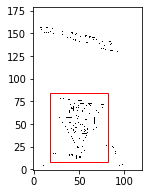

In [13]:
def plot_label(B,a):
    plt.figure(figsize=(12,3))
    B = np.repeat(B[...],3,-1) # convert to three dimensional
    plt.imshow(B, cmap='gray', interpolation='none', origin='lower')#, extent=[0,img_w,0,img_h])
    a = a*redim_vec
    plt.gca().add_patch(matplotlib.patches.Rectangle((a[0], a[1]), a[3], a[2], ec='r', fc='none'))
    
plot_label(X_train[3],y_train[3])

## Keras Neural Network

In [14]:
# Build the model.
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout, Conv2D, MaxPool2D, Flatten
from keras.optimizers import SGD

Using TensorFlow backend.


In [15]:
def model_conv(X_,y_):
    model = Sequential()
    model.add(Conv2D(filters=8, kernel_size=(3,3), padding='Same', activation='relu', 
                     input_shape=X_.shape[1:]))
    model.add(Conv2D(filters=8, kernel_size=(3,3), padding='Same', activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Conv2D(filters=16, kernel_size=(3,3), padding='Same', activation='relu'))
    model.add(Conv2D(filters=16, kernel_size=(3,3), padding='Same', activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
#     model.add(Conv2D(filters=32, kernel_size=(3,3), padding='Same', activation='relu'))
#     model.add(Conv2D(filters=32, kernel_size=(3,3), padding='Same', activation='relu'))
#     model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(y_.shape[-1]))

    model.summary()
    model.compile('adadelta','mse')
    return model

model = model_conv(X_,y_)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 180, 120, 8)       80        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 180, 120, 8)       584       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 90, 60, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 90, 60, 16)        1168      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 60, 16)        2320      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 45, 30, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 30, 32)       

In [ ]:
from keras.applications import imagenet_utils
from keras.applications import VGG16
from keras.applications import ResNet50, InceptionV3, MobileNet

def model_vgg(X_,y_):
    model = VGG16(weights="imagenet", include_top=False, # use without the classifier
                  input_shape=X_.shape[1:]) 
    
    x = Flatten()(model.output)
    x = Dense(1024, activation='relu')(x)
    x = Dense(1024, activation='relu')(x)
    x = Dense(y_.shape[-1])(x)
    
    new_model = Model(input=model.input, output=x)
    
    new_model.summary() 
    new_model.compile('adadelta','mse')
    return new_model

# model = model_vgg(X_,y_)

In [16]:
# Train.
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), verbose=2)

Train on 620 samples, validate on 156 samples
Epoch 1/20
 - 12s - loss: 0.0572 - val_loss: 0.0207
Epoch 2/20
 - 12s - loss: 0.0208 - val_loss: 0.0137
Epoch 3/20
 - 11s - loss: 0.0196 - val_loss: 0.0119
Epoch 4/20
 - 11s - loss: 0.0154 - val_loss: 0.0134
Epoch 5/20
 - 11s - loss: 0.0141 - val_loss: 0.0226
Epoch 6/20
 - 11s - loss: 0.0155 - val_loss: 0.0117
Epoch 7/20
 - 11s - loss: 0.0120 - val_loss: 0.0076
Epoch 8/20
 - 13s - loss: 0.0114 - val_loss: 0.0083
Epoch 9/20
 - 12s - loss: 0.0113 - val_loss: 0.0074
Epoch 10/20
 - 12s - loss: 0.0094 - val_loss: 0.0096
Epoch 11/20
 - 11s - loss: 0.0084 - val_loss: 0.0074
Epoch 12/20
 - 11s - loss: 0.0101 - val_loss: 0.0093
Epoch 13/20
 - 12s - loss: 0.0089 - val_loss: 0.0065
Epoch 14/20
 - 11s - loss: 0.0194 - val_loss: 0.0106
Epoch 15/20
 - 12s - loss: 0.0092 - val_loss: 0.0080
Epoch 16/20
 - 12s - loss: 0.0076 - val_loss: 0.0062
Epoch 17/20
 - 11s - loss: 0.0075 - val_loss: 0.0064
Epoch 18/20
 - 12s - loss: 0.0072 - val_loss: 0.0091
Epoch 19/

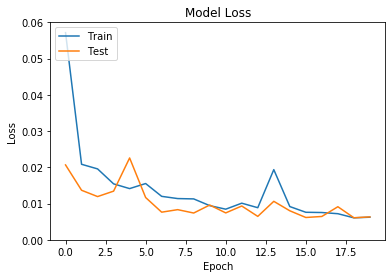

In [17]:
# Plot training and validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.ylim([0,0.06])
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('./history_rois_4.png')
plt.show()

### Save model

In [18]:
model.save_weights('./weights_rois_localize_5.h5')

In [19]:
model_json = model.to_json()
with open("model_rois_localize_5.json", "w") as json_file:
    json_file.write(model_json)

### Load model

In [27]:
from keras.models import load_model
# new_model = load_model('./model_rois_localize_4.json',compile=True)
# new_model.load_weights(filepath='./weights_rois_localize_4.h5')

## Predict

In [20]:
# Predict bounding boxes on the test images.
pred_y = model.predict(X_test)
pred_bboxes = (pred_y *redim_vec) /reduct
pred_bboxes = pred_bboxes.reshape(len(pred_bboxes), -1)
pred_bboxes.shape

(156, 4)

In [21]:
pred_bboxes[1]

array([136.70345843, 266.89830422, 456.99208975, 379.73299026])

### Show bounding boxes

In [22]:
def IOU(bbox1, bbox2):
    '''Calculate overlap between two bounding boxes [x, y, h, w] as the area of intersection over the area of unity'''
    x1, y1, h1, w1 = bbox1[0], bbox1[1], bbox1[2], bbox1[3]
    x2, y2, h2, w2 = bbox2[0], bbox2[1], bbox2[2], bbox2[3]

    w_I = min(x1 + w1, x2 + w2) - max(x1, x2)
    h_I = min(y1 + h1, y2 + h2) - max(y1, y2)
    if w_I <= 0 or h_I <= 0:  # no overlap
        return 0.
    I = w_I * h_I

    U = w1 * h1 + w2 * h2 - I

    return I / U

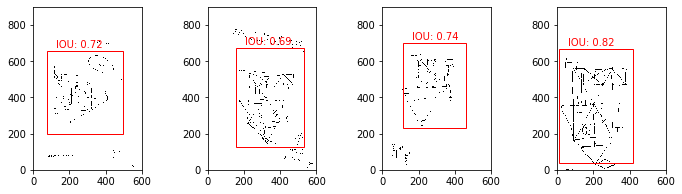

In [23]:
plt.figure(figsize=(12,3))
for i_subplot in range(1, 5):
    plt.subplot(1, 4, i_subplot)
    i = np.random.randint(len(X_test))
    B = X_test[i]
    B = np.repeat(B[...],3,-1) # convert to three dimensional
    plt.imshow(B, cmap='gray', interpolation='none', origin='lower', extent=[0,img_w,0,img_h])

    a = pred_bboxes[i]
    e = y_test[i]*redim_vec/reduct
    plt.gca().add_patch(matplotlib.patches.Rectangle((a[0], a[1]), a[3], a[2], ec='r', fc='none'))
    plt.annotate('IOU: {:.2f}'.format(IOU(a, e)), (a[0]+50, a[1]+a[2]+20), color='r')

### Calculate mean IOU

In [24]:
summed_IOU = 0.
for pred_bbox, test_bbox in zip(pred_bboxes, y_test):
    summed_IOU += IOU(pred_bbox, test_bbox*redim_vec/reduct)
mean_IOU = summed_IOU / len(pred_bboxes)
mean_IOU
# if it's zero there is no overlap

0.6979611987392308